In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

In [2]:
master_data = pd.read_csv('data/processed/master_nba_data.csv')

In [3]:
modeling_data = master_data[master_data['Has_Salary_Data'] == True].copy()

In [4]:
print(f"Total dataset: {len(master_data):,} player-seasons")
print(f"Modeling dataset: {len(modeling_data):,} player-seasons with salary data")

Total dataset: 3,360 player-seasons
Modeling dataset: 219 player-seasons with salary data


In [9]:
print(f"\nAvailable columns ({len(master_data.columns)}):")
for i, col in enumerate(sorted(master_data.columns)):
    if i % 4 == 0:
        print()
    print(f"{col:<20}", end="")
print()


Available columns (69):

2P                  2P%                 2PA                 3P                  
3P%                 3PA                 3PAr                APG                 
AST                 AST%                Age                 Awards              
BLK                 BLK%                BPM                 Career_Stage        
Current_Salary      DBPM                DRB                 DRB%                
DWS                 FG                  FG%                 FGA                 
FT                  FT%                 FTA                 FTr                 
G                   GS                  Has_Salary_Data     MP                  
MPG                 OBPM                ORB                 ORB%                
OWS                 PER                 PF                  PPG                 
PTS                 Player              Player_Clean        Points_Per_Million  
Pos                 RPG                 Reliable_Advanced_StatsRk                  

In [11]:
existing_performance_features = []
potential_features = ['PTS', 'TRB', 'AST', 'FG%', '3P%', 'FT%', 'PER', 'TS%', 'USG%', 'BPM', 'VORP', 'WS']
for feature in potential_features:
    if feature in master_data.columns:
        existing_performance_features.append(feature)

In [13]:
existing_advanced_features = []
potential_advanced = ['MPG', 'PPG', 'RPG', 'APG', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%']
for feature in potential_advanced:
    if feature in master_data.columns:
        existing_advanced_features.append(feature)

In [15]:
existing_contextual_features = []
potential_contextual = ['Age', 'G', 'GS', 'MP']
for feature in potential_contextual:
    if feature in master_data.columns:
        existing_contextual_features.append(feature)

In [17]:
print(f"\nExisting performance features: {existing_performance_features}")
print(f"Existing advanced features: {existing_advanced_features}")
print(f"Existing contextual features: {existing_contextual_features}")


Existing performance features: ['PTS', 'TRB', 'AST', 'FG%', '3P%', 'FT%', 'PER', 'TS%', 'USG%', 'BPM', 'VORP', 'WS']
Existing advanced features: ['MPG', 'PPG', 'RPG', 'APG', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%']
Existing contextual features: ['Age', 'G', 'GS', 'MP']


In [19]:
if 'Pos' in modeling_data.columns:
    position_dummies = pd.get_dummies(modeling_data['Pos'], prefix='Pos')
    print(f"Position dummies created: {list(position_dummies.columns)}")
else:
    position_dummies = pd.DataFrame()
    print("No position data available")

Position dummies created: ['Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG']


In [21]:
if 'Team_Clean' in modeling_data.columns:
    top_teams = modeling_data['Team_Clean'].value_counts().head(15).index
    modeling_data['Top_Team'] = modeling_data['Team_Clean'].isin(top_teams)
    print(f"Top teams identified: {len(top_teams)} teams")
else:
    modeling_data['Top_Team'] = False

Top teams identified: 15 teams


In [23]:
min_season = master_data['Season'].min()
modeling_data['Experience'] = modeling_data['Season'] - min_season
print(f"   Experience: years since {min_season}")

   Experience: years since 2020


In [25]:
if 'Age' in modeling_data.columns:
    modeling_data['Age_Squared'] = modeling_data['Age'] ** 2
    print("   Age_Squared: created")
else:
    modeling_data['Age_Squared'] = 0

   Age_Squared: created


In [27]:
if 'PTS' in modeling_data.columns and 'MP' in modeling_data.columns:
    modeling_data['PTS_per_MP'] = modeling_data['PTS'] / modeling_data['MP'].clip(lower=1)
    print("   PTS_per_MP: created")
else:
    modeling_data['PTS_per_MP'] = 0

   PTS_per_MP: created


In [29]:
# Efficiency score using available metrics
efficiency_components = []
weights = []

In [31]:
if 'PER' in modeling_data.columns:
    efficiency_components.append(modeling_data['PER'].fillna(15))  # 15 is league average PER
    weights.append(0.3)

if 'BPM' in modeling_data.columns:
    efficiency_components.append(modeling_data['BPM'].fillna(0))  # 0 is league average BPM
    weights.append(0.3)

if 'VORP' in modeling_data.columns:
    efficiency_components.append(modeling_data['VORP'].fillna(0))  # 0 is replacement level
    weights.append(0.4)

In [33]:
if efficiency_components:
    weights = np.array(weights) / sum(weights)
    modeling_data['Efficiency_Score'] = sum(w * comp for w, comp in zip(weights, efficiency_components))
    print(f"   Efficiency_Score: created using {len(efficiency_components)} components")
else:
    modeling_data['Efficiency_Score'] = 0
    print("   Efficiency_Score: using fallback (no advanced metrics)")

   Efficiency_Score: created using 3 components


In [35]:
feature_columns = (existing_performance_features + existing_advanced_features + 
                  existing_contextual_features + ['Experience', 'Age_Squared', 
                  'PTS_per_MP', 'Efficiency_Score', 'Top_Team'])

In [37]:
for col in feature_columns:
    if col in modeling_data.columns:
        before_na = modeling_data[col].isna().sum()
        modeling_data[col] = modeling_data[col].fillna(modeling_data[col].median())
        after_na = modeling_data[col].isna().sum()
        if before_na > 0:
            print(f"   {col}: filled {before_na} missing values")

In [39]:
master_data['Experience'] = master_data['Season'] - min_season

if 'Age' in master_data.columns:
    master_data['Age_Squared'] = master_data['Age'] ** 2
else:
    master_data['Age_Squared'] = 0

if 'PTS' in master_data.columns and 'MP' in master_data.columns:
    master_data['PTS_per_MP'] = master_data['PTS'] / master_data['MP'].clip(lower=1)
else:
    master_data['PTS_per_MP'] = 0

In [41]:
efficiency_components_all = []
if 'PER' in master_data.columns:
    efficiency_components_all.append(master_data['PER'].fillna(15) * 0.3)
if 'BPM' in master_data.columns:
    efficiency_components_all.append(master_data['BPM'].fillna(0) * 0.3)
if 'VORP' in master_data.columns:
    efficiency_components_all.append(master_data['VORP'].fillna(0) * 0.4)

In [43]:
if efficiency_components_all:
    master_data['Efficiency_Score'] = sum(efficiency_components_all)
else:
    master_data['Efficiency_Score'] = 0

In [45]:
if 'Team_Clean' in master_data.columns:
    master_data['Top_Team'] = master_data['Team_Clean'].isin(top_teams)
else:
    master_data['Top_Team'] = False

In [47]:
print(f"Total features for modeling: {len(feature_columns)}")
print(f"Features: {feature_columns}")

Total features for modeling: 31
Features: ['PTS', 'TRB', 'AST', 'FG%', '3P%', 'FT%', 'PER', 'TS%', 'USG%', 'BPM', 'VORP', 'WS', 'MPG', 'PPG', 'RPG', 'APG', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'Age', 'G', 'GS', 'MP', 'Experience', 'Age_Squared', 'PTS_per_MP', 'Efficiency_Score', 'Top_Team']


In [49]:
missing_features = [col for col in feature_columns if col not in modeling_data.columns]
if missing_features:
    print(f"\nWARNING: Still missing features: {missing_features}")
else:
    print(f"\n All {len(feature_columns)} features successfully created")


 All 31 features successfully created


### Model 1 - Salary Prediction

In [52]:
X = modeling_data[feature_columns].copy()
y = modeling_data['Current_Salary'].copy()

In [54]:
X = pd.concat([X, position_dummies], axis=1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

In [58]:
print(f"Training set: {len(X_train)} players")
print(f"Test set: {len(X_test)} players")

Training set: 175 players
Test set: 44 players


In [60]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
# Train Multiple Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [64]:
model_results = {}

In [66]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'r2': r2,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'predictions': y_pred
    }
    
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: ${np.sqrt(mse)/1000000:.2f}M")
    print(f"MAE: ${mae/1000000:.2f}M")


Training Linear Regression...
R² Score: 0.716
RMSE: $8.78M
MAE: $5.73M

Training Ridge Regression...
R² Score: 0.736
RMSE: $8.48M
MAE: $6.12M

Training Lasso Regression...
R² Score: 0.718
RMSE: $8.75M
MAE: $5.71M

Training Random Forest...
R² Score: 0.827
RMSE: $6.85M
MAE: $5.03M

Training Gradient Boosting...
R² Score: 0.750
RMSE: $8.24M
MAE: $5.93M


In [68]:
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
best_model = model_results[best_model_name]

In [70]:
print(f"\nBest Model: {best_model_name}")
print(f"R² Score: {best_model['r2']:.3f}")
print(f"RMSE: ${best_model['rmse']/1000000:.2f}M")


Best Model: Random Forest
R² Score: 0.827
RMSE: $6.85M


### Model 2 - Player Value Estimation

In [73]:
def classify_career_stage(age):
    if pd.isna(age):
        return 'Unknown'
    if age <= 23:
        return 'Rookie/Young'
    elif age <= 27:
        return 'Developing' 
    elif age <= 30:
        return 'Prime'
    elif age <= 34:
        return 'Veteran'
    else:
        return 'Late Career'

In [75]:
modeling_data['Age_Group'] = modeling_data['Age'].apply(classify_career_stage)

In [77]:
position_age_performance = modeling_data.groupby(['Pos', 'Age_Group'])['Efficiency_Score'].transform('median')
modeling_data['Performance_vs_Peers'] = modeling_data['Efficiency_Score'] / position_age_performance

In [79]:
modeling_data['Value_Score'] = (
    modeling_data['Performance_vs_Peers'] * 0.6 +
    modeling_data['Points_Per_Million'].fillna(0) * 0.0001 * 0.4
)

In [81]:
# Train value estimation model
X_value = modeling_data[feature_columns + ['Performance_vs_Peers']].copy()
X_value = pd.concat([X_value, position_dummies], axis=1)
y_value = modeling_data['Value_Score'].copy()

X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_value, y_value, test_size=0.2, random_state=42
)

In [83]:
value_model = RandomForestRegressor(n_estimators=150, random_state=42)
value_model.fit(X_val_train, y_val_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [85]:
y_val_pred = value_model.predict(X_val_test)
value_r2 = r2_score(y_val_test, y_val_pred)

In [87]:
print(f"Value Estimation Model R² Score: {value_r2:.3f}")

Value Estimation Model R² Score: 0.995


In [89]:
required_features = feature_columns

In [91]:
for feature in required_features:
    if feature not in master_data.columns:
        print(f"Creating missing feature: {feature}")
        if feature == 'Experience':
            master_data['Experience'] = master_data['Season'] - master_data['Season'].min()
        elif feature == 'Age_Squared':
            master_data['Age_Squared'] = master_data['Age'].fillna(25) ** 2
        elif feature == 'PTS_per_MP':
            master_data['PTS_per_MP'] = master_data['PTS'] / master_data['MP'].clip(lower=1)
        elif feature == 'Efficiency_Score':
            # Recreate efficiency score
            efficiency_components = []
            if 'PER' in master_data.columns:
                efficiency_components.append(master_data['PER'].fillna(15) * 0.3)
            if 'BPM' in master_data.columns:
                efficiency_components.append(master_data['BPM'].fillna(0) * 0.3)
            if 'VORP' in master_data.columns:
                efficiency_components.append(master_data['VORP'].fillna(0) * 0.4)
            
            if efficiency_components:
                master_data['Efficiency_Score'] = sum(efficiency_components)
            else:
                master_data['Efficiency_Score'] = 0
        elif feature == 'Top_Team':
            # Use the same top teams identified during modeling
            if 'Team_Clean' in master_data.columns:
                top_teams = modeling_data['Team_Clean'].value_counts().head(15).index
                master_data['Top_Team'] = master_data['Team_Clean'].isin(top_teams)
            else:
                master_data['Top_Team'] = False

In [92]:
available_features = [col for col in feature_columns if col in master_data.columns]
print(f"Available features: {len(available_features)} of {len(feature_columns)}")

Available features: 31 of 31


In [93]:
all_features = master_data[available_features].copy()

In [94]:
for col in all_features.columns:
    before_na = all_features[col].isna().sum()
    if before_na > 0:
        if col in modeling_data.columns:
            fill_value = modeling_data[col].median()
        else:
            fill_value = all_features[col].median()

        if pd.isna(fill_value):
            if col == 'Age':
                fill_value = 25
            elif col in ['PER']:
                fill_value = 15 
            elif col in ['BPM', 'VORP']:
                fill_value = 0   
            else:
                fill_value = 0
        
        all_features[col] = all_features[col].fillna(fill_value)
        print(f"   {col}: filled {before_na} missing values with {fill_value}")

   FG%: filled 6 missing values with 0.451
   3P%: filled 6 missing values with 0.343
   FT%: filled 6 missing values with 0.78
   Age: filled 6 missing values with 24.0
   Age_Squared: filled 6 missing values with 576.0


In [95]:
if 'Pos' in master_data.columns:
    all_positions = pd.get_dummies(master_data['Pos'], prefix='Pos')
    
    # Ensure all position columns from modeling exist
    for col in position_dummies.columns:
        if col not in all_positions.columns:
            all_positions[col] = 0
            print(f"   Added missing position column: {col}")
    
    # Reorder columns to match modeling data
    position_columns = [col for col in position_dummies.columns if col in all_positions.columns]
    all_positions = all_positions[position_columns]
else:
    # Create dummy position dataframe if no position data
    all_positions = pd.DataFrame(0, index=master_data.index, columns=position_dummies.columns)
    print("   No position data - using zeros")


In [96]:
if 'Career_Stage' in master_data.columns:
    master_data['Age_Group'] = master_data['Career_Stage']
else:
    def classify_career_stage(age):
        if pd.isna(age):
            return 'Unknown'
        if age <= 23:
            return 'Rookie/Young'
        elif age <= 27:
            return 'Developing'
        elif age <= 30:
            return 'Prime'
        elif age <= 34:
            return 'Veteran'
        else:
            return 'Late Career'
    
    master_data['Age_Group'] = master_data['Age'].fillna(25).apply(classify_career_stage)

In [97]:
if 'Efficiency_Score' not in master_data.columns:
    print("Creating Efficiency_Score for all players...")
    efficiency_components = []
    if 'PER' in master_data.columns:
        efficiency_components.append(master_data['PER'].fillna(15) * 0.3)
    if 'BPM' in master_data.columns:
        efficiency_components.append(master_data['BPM'].fillna(0) * 0.3)
    if 'VORP' in master_data.columns:
        efficiency_components.append(master_data['VORP'].fillna(0) * 0.4)
    
    if efficiency_components:
        master_data['Efficiency_Score'] = sum(efficiency_components)
    else:
        master_data['Efficiency_Score'] = 0

In [98]:
pos_age_perf = master_data.groupby(['Pos', 'Age_Group'])['Efficiency_Score'].median()

In [99]:
def get_performance_vs_peers(row):
    pos = row['Pos']
    age_group = row['Age_Group']
    efficiency = row['Efficiency_Score']
    
    try:
        benchmark = pos_age_perf.loc[(pos, age_group)]
        if pd.isna(benchmark) or benchmark == 0:
            # Use position average if age group benchmark missing
            pos_avg = master_data[master_data['Pos'] == pos]['Efficiency_Score'].median()
            benchmark = pos_avg if not pd.isna(pos_avg) and pos_avg != 0 else 1
    except KeyError:
        # Use overall position average
        pos_avg = master_data[master_data['Pos'] == pos]['Efficiency_Score'].median()
        benchmark = pos_avg if not pd.isna(pos_avg) and pos_avg != 0 else 1
    
    return efficiency / benchmark if benchmark != 0 else 1

In [100]:
master_data['Performance_vs_Peers'] = master_data.apply(get_performance_vs_peers, axis=1)

In [101]:
master_data['Performance_vs_Peers'] = master_data['Performance_vs_Peers'].fillna(1.0)

In [102]:
# Combine all features
X_all_value = pd.concat([
    all_features, 
    master_data[['Performance_vs_Peers']], 
    all_positions
], axis=1)

In [103]:
nan_count = X_all_value.isna().sum().sum()
if nan_count > 0:
    print(f"WARNING: {nan_count} NaN values detected. Filling with zeros...")
    X_all_value = X_all_value.fillna(0)

In [104]:
print(f"Final prediction matrix shape: {X_all_value.shape}")
print(f"Features match training data: {X_all_value.shape[1] == X_val_train.shape[1]}")

Final prediction matrix shape: (3360, 37)
Features match training data: True


In [105]:
master_data['Predicted_Value'] = value_model.predict(X_all_value)

In [106]:
print(f"Value predictions generated for all {len(master_data)} players!")
print(f"Value range: {master_data['Predicted_Value'].min():.3f} to {master_data['Predicted_Value'].max():.3f}")

Value predictions generated for all 3360 players!
Value range: -0.268 to 2.301


In [107]:
print("\nTop 5 highest predicted values:")
top_values = master_data.nlargest(5, 'Predicted_Value')[['Player_Clean', 'Team_Clean', 'Predicted_Value', 'Season']]
for _, player in top_values.iterrows():
    print(f"   {player['Player_Clean']} ({player['Season']}): {player['Predicted_Value']:.3f}")


Top 5 highest predicted values:
   Anthony Edwards (2025): 2.301
   Shai Gilgeous-Alexander (2025): 2.120
   Jayson Tatum (2022): 2.112
   Trae Young (2022): 2.094
   Jayson Tatum (2023): 2.080


### Model 3 - Contract Efficiency Scoring

In [109]:
def calculate_efficiency_scores_fixed(df):
    """Calculate multiple efficiency metrics - FIXED VERSION"""
    
    df = df.copy()  # Don't modify original
    
    # Check if we have salary data
    if 'Current_Salary' not in df.columns:
        print("No salary data available for efficiency scoring")
        return df
    
    # Basic efficiency metrics
    print("Calculating basic efficiency metrics...")
    
    # Points per dollar (handle missing salaries)
    salary_median = df['Current_Salary'].median()
    df['Points_Per_Dollar'] = df['PTS'] / (df['Current_Salary'].fillna(salary_median) / 1000000)
    
    # Win Shares per dollar (if available)
    if 'WS' in df.columns:
        df['WinShares_Per_Dollar'] = df['WS'] / (df['Current_Salary'].fillna(salary_median) / 1000000)
    else:
        df['WinShares_Per_Dollar'] = 0
        print("   WS column not found, using 0 for WinShares_Per_Dollar")
    
    # VORP per dollar (if available)
    if 'VORP' in df.columns:
        df['VORP_Per_Dollar'] = df['VORP'] / (df['Current_Salary'].fillna(salary_median) / 1000000)
    else:
        df['VORP_Per_Dollar'] = 0
        print("   VORP column not found, using 0 for VORP_Per_Dollar")
    
    # Composite efficiency score
    print("Creating composite efficiency score...")
    
    # Normalize each component (handle division by zero)
    max_points = df['Points_Per_Dollar'].max() if df['Points_Per_Dollar'].max() > 0 else 1
    max_ws = df['WinShares_Per_Dollar'].max() if df['WinShares_Per_Dollar'].max() > 0 else 1
    max_vorp = df['VORP_Per_Dollar'].max() if df['VORP_Per_Dollar'].max() > 0 else 1
    
    df['Efficiency_Composite'] = (
        (df['Points_Per_Dollar'] / max_points) * 0.3 +
        (df['WinShares_Per_Dollar'] / max_ws) * 0.4 +
        (df['VORP_Per_Dollar'] / max_vorp) * 0.3
    )
    
    # Risk-adjusted efficiency (account for age)
    print("Calculating risk-adjusted efficiency...")
    
    age_factor = 1 - (df['Age'].fillna(25) - 22) * 0.02  # Decrease value as age increases
    age_factor = age_factor.clip(lower=0.5)  # Minimum factor of 0.5
    
    df['Risk_Adjusted_Efficiency'] = df['Efficiency_Composite'] * age_factor
    
    # Contract tier analysis
    print("Assigning contract tiers...")
    
    salary_percentiles = df['Current_Salary'].quantile([0.25, 0.5, 0.75, 0.9])
    
    def get_efficiency_tier(row):
        salary = row['Current_Salary']
        efficiency = row['Risk_Adjusted_Efficiency']
        
        if pd.isna(salary):
            return 'Unknown'
        
        if salary <= salary_percentiles[0.25]:
            return 'Bargain' if efficiency > 0.6 else 'Fair'
        elif salary <= salary_percentiles[0.5]:
            return 'Good Value' if efficiency > 0.4 else 'Fair'
        elif salary <= salary_percentiles[0.75]:
            return 'Fair' if efficiency > 0.3 else 'Overpaid'
        else:
            return 'Fair' if efficiency > 0.2 else 'Overpaid'
    
    df['Contract_Tier'] = df.apply(get_efficiency_tier, axis=1)
    
    print(f"Contract tiers assigned:")
    tier_counts = df['Contract_Tier'].value_counts()
    for tier, count in tier_counts.items():
        print(f"   {tier}: {count} players")
    
    return df

In [110]:
modeling_data = calculate_efficiency_scores_fixed(modeling_data)

Calculating basic efficiency metrics...
Creating composite efficiency score...
Calculating risk-adjusted efficiency...
Assigning contract tiers...
Contract tiers assigned:
   Overpaid: 109 players
   Fair: 106 players
   Good Value: 2 players
   Bargain: 2 players


In [111]:
contract_features = [
    'Age', 'PER', 'BPM', 'VORP', 'WS', 'USG%', 'TS%',
    'PPG', 'RPG', 'APG', 'Efficiency_Score', 'Performance_vs_Peers'
]

In [112]:
available_contract_features = []
for feature in contract_features:
    if feature in modeling_data.columns:
        available_contract_features.append(feature)
    else:
        print(f"   Warning: {feature} not available, skipping")

print(f"Using {len(available_contract_features)} features for contract model: {available_contract_features}")

Using 12 features for contract model: ['Age', 'PER', 'BPM', 'VORP', 'WS', 'USG%', 'TS%', 'PPG', 'RPG', 'APG', 'Efficiency_Score', 'Performance_vs_Peers']


In [113]:
modeling_data['Good_Contract'] = (
    (modeling_data['Contract_Tier'].isin(['Bargain', 'Good Value'])) | 
    (modeling_data['Risk_Adjusted_Efficiency'] > 0.4)
).astype(int)

In [114]:
good_contracts = modeling_data['Good_Contract'].sum()
total_contracts = len(modeling_data)
print(f"Good contracts: {good_contracts}/{total_contracts} ({good_contracts/total_contracts*100:.1f}%)")

Good contracts: 9/219 (4.1%)


In [115]:
X_contract = modeling_data[available_contract_features].fillna(modeling_data[available_contract_features].median())
y_contract = modeling_data['Good_Contract']

In [116]:
if len(X_contract) < 20:
    print("Warning: Very small dataset for contract model")
    test_size = 0.3
else:
    test_size = 0.2

X_cont_train, X_cont_test, y_cont_train, y_cont_test = train_test_split(
    X_contract, y_contract, test_size=test_size, random_state=42, stratify=y_contract
)

In [117]:
print(f"Training set: {len(X_cont_train)} contracts")
print(f"Test set: {len(X_cont_test)} contracts")

Training set: 175 contracts
Test set: 44 contracts


In [118]:
contract_model = RandomForestClassifier(n_estimators=100, random_state=42)
contract_model.fit(X_cont_train, y_cont_train)

RandomForestClassifier(random_state=42)

In [119]:
y_cont_pred = contract_model.predict(X_cont_test)
contract_accuracy = accuracy_score(y_cont_test, y_cont_pred)

In [120]:
print(f"\nContract Classification Accuracy: {contract_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_cont_test, y_cont_pred, target_names=['Bad Contract', 'Good Contract']))


Contract Classification Accuracy: 0.955

Classification Report:
               precision    recall  f1-score   support

 Bad Contract       0.95      1.00      0.98        42
Good Contract       0.00      0.00      0.00         2

     accuracy                           0.95        44
    macro avg       0.48      0.50      0.49        44
 weighted avg       0.91      0.95      0.93        44



There is some class imbalance in the code above. 42 bad contratcs vs only 2 good contracts is off. Below I am trying different approaches to understand the current distribution.

In [122]:
print("Analyzing contract distribution...")
print("Current contract tiers:")
print(modeling_data['Contract_Tier'].value_counts())
print(f"\nCurrent efficiency scores:")
print(f"Risk_Adjusted_Efficiency range: {modeling_data['Risk_Adjusted_Efficiency'].min():.3f} to {modeling_data['Risk_Adjusted_Efficiency'].max():.3f}")
print(f"Risk_Adjusted_Efficiency median: {modeling_data['Risk_Adjusted_Efficiency'].median():.3f}")

Analyzing contract distribution...
Current contract tiers:
Contract_Tier
Overpaid      109
Fair          106
Good Value      2
Bargain         2
Name: count, dtype: int64

Current efficiency scores:
Risk_Adjusted_Efficiency range: -0.134 to 0.863
Risk_Adjusted_Efficiency median: 0.081


In [123]:
print("\n=== OPTION 1: More Balanced Criteria ===")
modeling_data['Good_Contract_v2'] = (
    (modeling_data['Contract_Tier'].isin(['Bargain', 'Good Value', 'Fair'])) | 
    (modeling_data['Risk_Adjusted_Efficiency'] > modeling_data['Risk_Adjusted_Efficiency'].median())
).astype(int)

good_contracts_v2 = modeling_data['Good_Contract_v2'].sum()
print(f"Balanced approach: {good_contracts_v2}/{len(modeling_data)} good contracts ({good_contracts_v2/len(modeling_data)*100:.1f}%)")


=== OPTION 1: More Balanced Criteria ===
Balanced approach: 152/219 good contracts (69.4%)


In [124]:
print("\n=== OPTION 2: Percentile-Based ===")

efficiency_threshold = modeling_data['Risk_Adjusted_Efficiency'].quantile(0.7)
modeling_data['Good_Contract_v3'] = (
    modeling_data['Risk_Adjusted_Efficiency'] > efficiency_threshold
).astype(int)

good_contracts_v3 = modeling_data['Good_Contract_v3'].sum()
print(f"Top 30% approach: {good_contracts_v3}/{len(modeling_data)} good contracts ({good_contracts_v3/len(modeling_data)*100:.1f}%)")



=== OPTION 2: Percentile-Based ===
Top 30% approach: 66/219 good contracts (30.1%)


In [125]:
print("\n=== OPTION 3: Multi-Class Contract Rating ===")

def classify_contract_quality(row):
    """Create 3-class contract rating"""
    tier = row['Contract_Tier']
    efficiency = row['Risk_Adjusted_Efficiency']

    if tier in ['Bargain'] or efficiency > modeling_data['Risk_Adjusted_Efficiency'].quantile(0.8):
        return 'Excellent'
    elif tier in ['Good Value', 'Fair'] or efficiency > modeling_data['Risk_Adjusted_Efficiency'].quantile(0.4):
        return 'Good'
    else:
        return 'Poor'

modeling_data['Contract_Quality'] = modeling_data.apply(classify_contract_quality, axis=1)
print("Contract quality distribution:")
print(modeling_data['Contract_Quality'].value_counts())


=== OPTION 3: Multi-Class Contract Rating ===
Contract quality distribution:
Contract_Quality
Good         125
Poor          50
Excellent     44
Name: count, dtype: int64


Option 2 is slightly better given the more reasonable threshold.

In [127]:
y_contract_balanced = modeling_data['Good_Contract_v3']

# Check class balance
print(f"Class distribution:")
print(f"Bad contracts (0): {(y_contract_balanced == 0).sum()}")
print(f"Good contracts (1): {(y_contract_balanced == 1).sum()}")

Class distribution:
Bad contracts (0): 153
Good contracts (1): 66


In [128]:
X_cont_train_bal, X_cont_test_bal, y_cont_train_bal, y_cont_test_bal = train_test_split(
    X_contract, y_contract_balanced, test_size=0.2, random_state=42, stratify=y_contract_balanced
)

In [129]:
contract_model_balanced = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced'
)

contract_model_balanced.fit(X_cont_train_bal, y_cont_train_bal)

y_cont_pred_bal = contract_model_balanced.predict(X_cont_test_bal)
contract_accuracy_bal = accuracy_score(y_cont_test_bal, y_cont_pred_bal)

In [130]:
print(f"\nBalanced Contract Classification Accuracy: {contract_accuracy_bal:.3f}")
print("\nBalanced Classification Report:")
print(classification_report(y_cont_test_bal, y_cont_pred_bal, target_names=['Bad Contract', 'Good Contract']))


Balanced Contract Classification Accuracy: 0.750

Balanced Classification Report:
               precision    recall  f1-score   support

 Bad Contract       0.81      0.84      0.83        31
Good Contract       0.58      0.54      0.56        13

     accuracy                           0.75        44
    macro avg       0.70      0.69      0.69        44
 weighted avg       0.74      0.75      0.75        44



In [131]:
contract_model = contract_model_balanced
contract_accuracy = contract_accuracy_bal

In [132]:
print(f"\nExample contract classifications:")
sample_predictions = modeling_data.sample(5)[['Player_Clean', 'Current_Salary', 'Risk_Adjusted_Efficiency', 'Contract_Tier', 'Good_Contract_v3']]
for _, player in sample_predictions.iterrows():
    status = "GOOD" if player['Good_Contract_v3'] else "BAD"
    print(f"   {player['Player_Clean']}: ${player['Current_Salary']/1000000:.1f}M - {status} contract")


Example contract classifications:
   Cody Williams: $5.7M - BAD contract
   Matas Buzelis: $5.5M - GOOD contract
   Kyle Kuzma: $22.4M - BAD contract
   Sam Hauser: $10.0M - GOOD contract
   Pelle Larsson: $2.0M - GOOD contract


### Feature Importance and Model Validation

In [134]:
def analyze_feature_importance(model, feature_names, model_name):
    """Analyze and plot feature importance"""
    
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Features - {model_name}:")
        print(importance_df.head(10).to_string(index=False))

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df.head(15)['feature'][::-1], importance_df.head(15)['importance'][::-1])
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    return None


Top 10 Features - Random Forest (Salary Prediction):
    feature  importance
        PPG    0.655231
        MPG    0.092021
Age_Squared    0.036891
        Age    0.033450
        PER    0.017629
         WS    0.015045
       STL%    0.012933
        PTS    0.012739
       BLK%    0.012006
         GS    0.011615


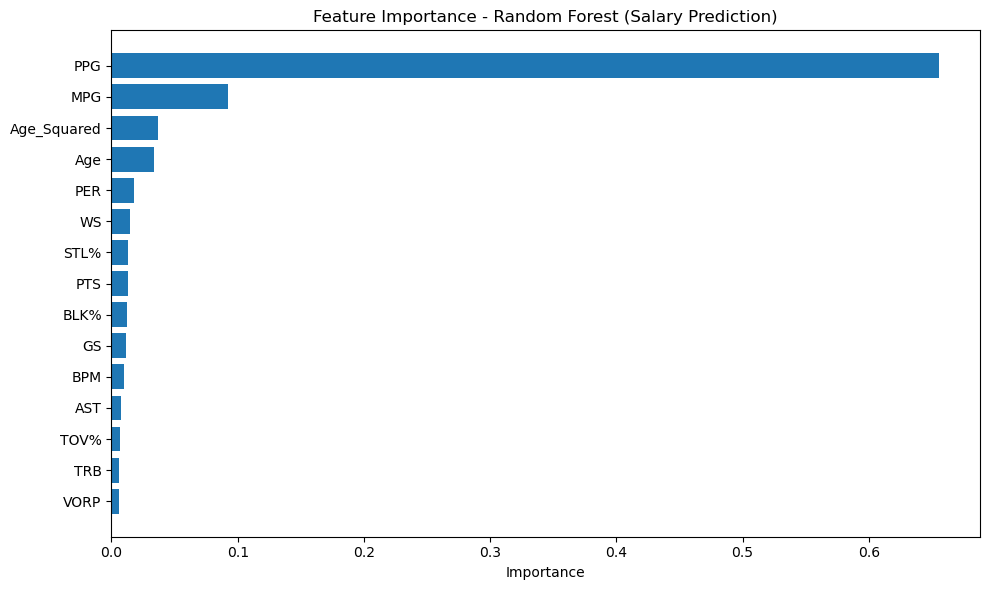

In [135]:
if 'Random Forest' in best_model_name or 'Gradient' in best_model_name:
    salary_importance = analyze_feature_importance(
        best_model['model'], 
        X.columns, 
        f"{best_model_name} (Salary Prediction)"
    )


Top 10 Features - Value Estimation Model:
             feature  importance
Performance_vs_Peers    0.948091
    Efficiency_Score    0.007275
                  MP    0.006043
                 BPM    0.004998
                 PER    0.003768
                 PPG    0.003585
                 PTS    0.003063
                  WS    0.003001
                 TS%    0.002761
                VORP    0.002519


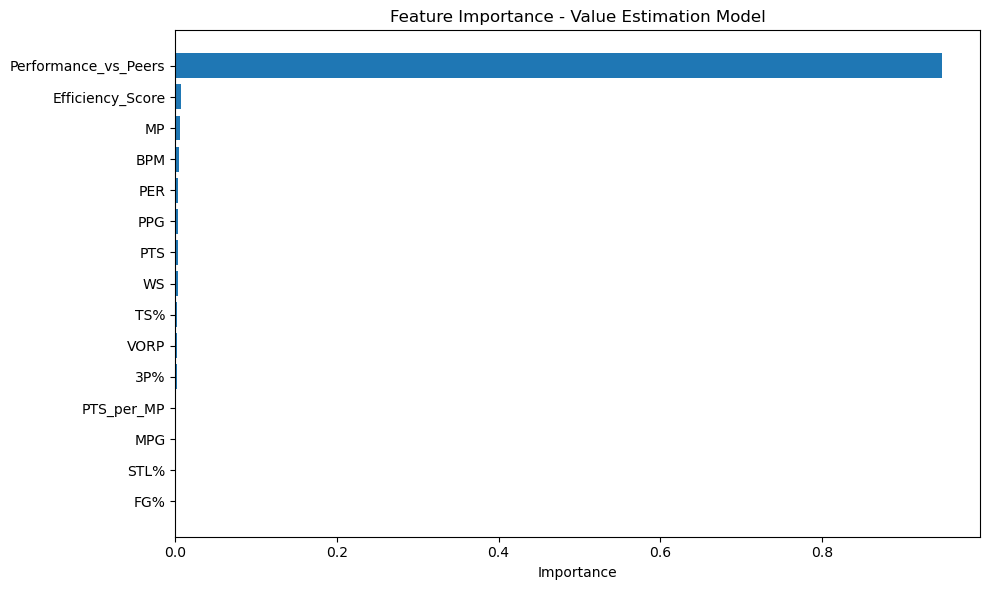

In [136]:
value_importance = analyze_feature_importance(
    value_model, 
    X_value.columns, 
    "Value Estimation Model"
)


Top 10 Features - Contract Classification Model:
             feature  importance
                 PPG    0.141185
                  WS    0.139947
                USG%    0.101352
                 Age    0.099153
                 TS%    0.094251
Performance_vs_Peers    0.078925
    Efficiency_Score    0.077670
                 BPM    0.068252
                 APG    0.065539
                 PER    0.058964


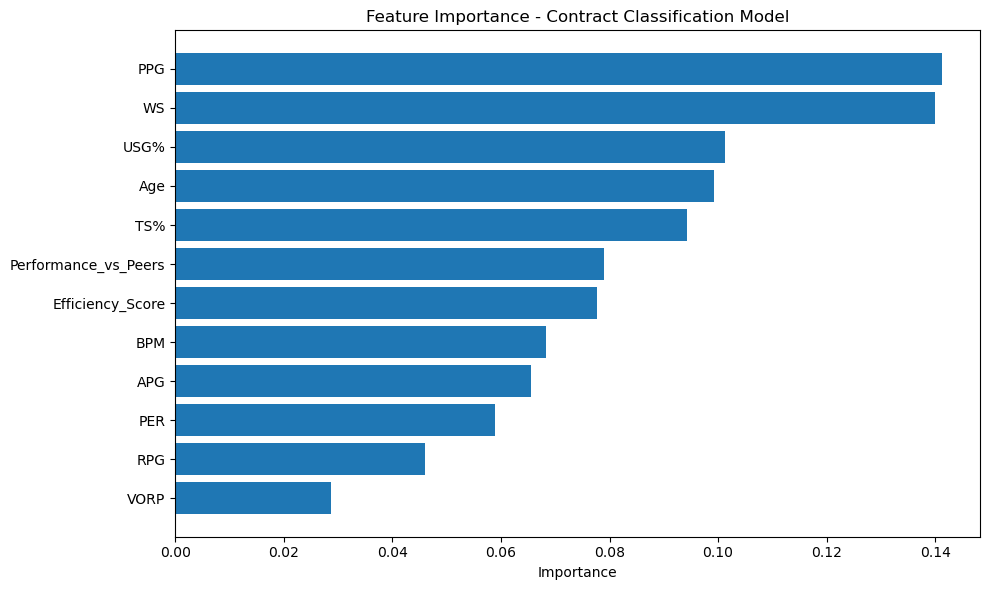

In [137]:
contract_importance = analyze_feature_importance(
    contract_model, 
    contract_features, 
    "Contract Classification Model"
)

In [138]:
if 'Random Forest' in best_model_name:
    cv_scores = cross_val_score(best_model['model'], X_train, y_train, cv=5, scoring='r2')
    print(f"Salary Model CV R² Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Salary Model CV R² Score: 0.742 ± 0.143


In [139]:
cv_value_scores = cross_val_score(value_model, X_val_train, y_val_train, cv=5, scoring='r2')
print(f"Value Model CV R² Score: {cv_value_scores.mean():.3f} ± {cv_value_scores.std():.3f}")

Value Model CV R² Score: 0.962 ± 0.039


In [140]:
cv_contract_scores = cross_val_score(contract_model, X_cont_train, y_cont_train, cv=5, scoring='accuracy')
print(f"Contract Model CV Accuracy: {cv_contract_scores.mean():.3f} ± {cv_contract_scores.std():.3f}")

Contract Model CV Accuracy: 0.960 ± 0.014


### Save Models and Insight Generation

In [142]:
os.makedirs('results/models', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)

In [143]:
models_to_save = {
    'salary_prediction_model': best_model['model'],
    'value_estimation_model': value_model,
    'contract_classification_model': contract_model,
    'feature_scaler': scaler
}

In [144]:
for name, model in models_to_save.items():
    joblib.dump(model, f'results/models/{name}.pkl')
    print(f"Saved {name}")

Saved salary_prediction_model
Saved value_estimation_model
Saved contract_classification_model
Saved feature_scaler


In [145]:
master_data = calculate_efficiency_scores_fixed(master_data)

Calculating basic efficiency metrics...
Creating composite efficiency score...
Calculating risk-adjusted efficiency...
Assigning contract tiers...
Contract tiers assigned:
   Unknown: 3141 players
   Overpaid: 109 players
   Fair: 106 players
   Bargain: 3 players
   Good Value: 1 players


In [146]:
all_contract_features = master_data[available_contract_features].copy()

In [147]:
for col in all_contract_features.columns:
    if col in modeling_data.columns:
        # Fill value from modeling data
        fill_value = modeling_data[col].median()
    else:
        fill_value = all_contract_features[col].median()
    
    # Handle case where median is still NaN
    if pd.isna(fill_value):
        if col == 'Age':
            fill_value = 25
        elif col == 'PER':
            fill_value = 15
        elif col in ['BPM', 'VORP']:
            fill_value = 0
        else:
            fill_value = 0
    
    all_contract_features[col] = all_contract_features[col].fillna(fill_value)

print(f"Feature matrix shape for all players: {all_contract_features.shape}")

Feature matrix shape for all players: (3360, 12)


In [148]:
master_data['Contract_Recommendation'] = contract_model.predict_proba(all_contract_features)[:, 1]

print(f"Contract recommendations generated for all {len(master_data)} players!")
print(f"Recommendation range: {master_data['Contract_Recommendation'].min():.3f} to {master_data['Contract_Recommendation'].max():.3f}")

Contract recommendations generated for all 3360 players!
Recommendation range: 0.000 to 0.960


In [149]:
undervalued = master_data[
    (master_data['Has_Salary_Data'] == True) & 
    (master_data['Contract_Recommendation'] > 0.7)
].nlargest(10, 'Risk_Adjusted_Efficiency')

In [150]:
print(f"\nTop 10 Undervalued Players:")
if len(undervalued) > 0:
    for idx, player in undervalued.iterrows():
        salary_mil = player['Current_Salary']/1000000 if pd.notna(player['Current_Salary']) else 0
        print(f"   {player['Player_Clean']}: ${salary_mil:.1f}M, "
              f"Efficiency: {player['Risk_Adjusted_Efficiency']:.3f}, "
              f"Rec Score: {player['Contract_Recommendation']:.3f}")
else:
    print("   No players meet the strict undervalued criteria (>0.7 recommendation)")
    print("   Showing top efficiency players instead:")

    top_efficiency = master_data[
        master_data['Has_Salary_Data'] == True
    ].nlargest(10, 'Risk_Adjusted_Efficiency')
    
    for idx, player in top_efficiency.iterrows():
        salary_mil = player['Current_Salary']/1000000 if pd.notna(player['Current_Salary']) else 0
        rec_score = player['Contract_Recommendation'] if 'Contract_Recommendation' in player else 0
        print(f"   {player['Player_Clean']}: ${salary_mil:.1f}M, "
              f"Efficiency: {player['Risk_Adjusted_Efficiency']:.3f}, "
              f"Rec Score: {rec_score:.3f}")


Top 10 Undervalued Players:
   Scotty Pippen Jr.: $2.3M, Efficiency: 0.779, Rec Score: 0.770
   Trayce Jackson-Davis: $2.2M, Efficiency: 0.475, Rec Score: 0.890
   Justin Champagnie: $2.3M, Efficiency: 0.421, Rec Score: 0.810
   Jay Huff: $2.3M, Efficiency: 0.412, Rec Score: 0.920
   Payton Pritchard: $7.2M, Efficiency: 0.398, Rec Score: 0.800
   Vit Krejci: $2.3M, Efficiency: 0.394, Rec Score: 0.890
   Julian Champagnie: $3.0M, Efficiency: 0.366, Rec Score: 0.720
   Moussa Diabaté: $2.3M, Efficiency: 0.360, Rec Score: 0.910
   Kyle Filipowski: $3.0M, Efficiency: 0.351, Rec Score: 0.870
   Neemias Queta: $2.3M, Efficiency: 0.341, Rec Score: 0.880


In [213]:
salary_stats = master_data[master_data['Has_Salary_Data'] == True]['Current_Salary'].describe()
median_salary = salary_stats['50%']
q75_salary = salary_stats['75%']

In [215]:
print(f"Salary distribution:")
print(f"   Median salary: ${median_salary/1000000:.1f}M")
print(f"   75th percentile: ${q75_salary/1000000:.1f}M")
print(f"   Using ${median_salary/1000000:.1f}M+ as 'significant contract' threshold")

Salary distribution:
   Median salary: $10.0M
   75th percentile: $25.6M
   Using $10.0M+ as 'significant contract' threshold


In [153]:
# Model performance summary
print(f"\nModel Performance Summary:")
print(f"   Salary Prediction R²: {best_model['r2']:.3f}")
print(f"   Value Estimation R²: {value_r2:.3f}")
print(f"   Contract Classification Accuracy: {contract_accuracy:.3f}")

#Save updated dataset
master_data.to_csv('data/processed/master_nba_data_with_models.csv', index=False)
print(f"\nUpdated dataset saved: {len(master_data):,} player-seasons")


Model Performance Summary:
   Salary Prediction R²: 0.827
   Value Estimation R²: 0.995
   Contract Classification Accuracy: 0.750

Updated dataset saved: 3,360 player-seasons


In [217]:
overpaid_significant = master_data[
    (master_data['Has_Salary_Data'] == True) & 
    (master_data['Current_Salary'] >= median_salary) &  # Only significant contracts
    (master_data['Contract_Recommendation'] < 0.4)     # Poor contract recommendation
].nsmallest(10, 'Risk_Adjusted_Efficiency')

In [219]:
print(f"\nTop 10 Overpaid Players (${median_salary/1000000:.1f}M+ contracts):")
if len(overpaid_significant) > 0:
    for idx, player in overpaid_significant.iterrows():
        salary_mil = player['Current_Salary']/1000000
        print(f"   {player['Player_Clean']}: ${salary_mil:.1f}M, "
              f"Efficiency: {player['Risk_Adjusted_Efficiency']:.3f}, "
              f"Rec Score: {player['Contract_Recommendation']:.3f}")
else:
    print("   No players meet overpaid criteria with significant contracts")

    print(f"\n   Alternative - Highest paid players with lowest efficiency:")
    high_paid_low_efficiency = master_data[
        (master_data['Has_Salary_Data'] == True) &
        (master_data['Current_Salary'] >= q75_salary)  # Top 25% of salaries
    ].nsmallest(10, 'Risk_Adjusted_Efficiency')
    
    for idx, player in high_paid_low_efficiency.iterrows():
        salary_mil = player['Current_Salary']/1000000
        rec_score = player.get('Contract_Recommendation', 0)
        print(f"   {player['Player_Clean']}: ${salary_mil:.1f}M, "
              f"Efficiency: {player['Risk_Adjusted_Efficiency']:.3f}, "
              f"Rec Score: {rec_score:.3f}")


Top 10 Overpaid Players ($10.0M+ contracts):
   Kyle Kuzma: $22.4M, Efficiency: 0.005, Rec Score: 0.030
   Herbert Jones: $13.9M, Efficiency: 0.009, Rec Score: 0.040
   Brandon Ingram: $38.1M, Efficiency: 0.009, Rec Score: 0.030
   Paul George: $51.7M, Efficiency: 0.012, Rec Score: 0.050
   Joel Embiid: $55.2M, Efficiency: 0.012, Rec Score: 0.030
   Dejounte Murray: $31.6M, Efficiency: 0.013, Rec Score: 0.020
   Patrick Williams: $18.0M, Efficiency: 0.015, Rec Score: 0.000
   Grant Williams: $13.6M, Efficiency: 0.018, Rec Score: 0.090
   Jalen Suggs: $35.0M, Efficiency: 0.021, Rec Score: 0.100
   Josh Green: $13.7M, Efficiency: 0.021, Rec Score: 0.090


In [223]:
print(f"\nContract Value Analysis:")

value_vs_salary = master_data[
    (master_data['Has_Salary_Data'] == True) &
    (master_data['Current_Salary'] >= median_salary)
].copy()

if 'Predicted_Value' in value_vs_salary.columns:
    value_vs_salary['Salary_to_Value_Ratio'] = (
        (value_vs_salary['Current_Salary'] / 1000000) / 
        value_vs_salary['Predicted_Value'].clip(lower=0.1)  # Avoid division by near-zero
    )
    
    # Highest salary-to-value ratios = most overpaid
    most_overpaid = value_vs_salary.nlargest(10, 'Salary_to_Value_Ratio')
    
    print(f"\nMost Overpaid by Salary-to-Value Ratio:")
    for idx, player in most_overpaid.iterrows():
        salary_mil = player['Current_Salary']/1000000
        ratio = player['Salary_to_Value_Ratio']
        print(f"   {player['Player_Clean']}: ${salary_mil:.1f}M, "
              f"Value: {player['Predicted_Value']:.2f}, "
              f"Ratio: {ratio:.1f}x overpaid")


Contract Value Analysis:

Most Overpaid by Salary-to-Value Ratio:
   Kyle Kuzma: $22.4M, Value: 0.14, Ratio: 154.7x overpaid
   Josh Green: $13.7M, Value: 0.11, Ratio: 126.2x overpaid
   Paul George: $51.7M, Value: 0.60, Ratio: 85.7x overpaid
   Jerami Grant: $32.0M, Value: 0.39, Ratio: 81.1x overpaid
   Patrick Williams: $18.0M, Value: 0.24, Ratio: 73.5x overpaid
   Lauri Markkanen: $46.4M, Value: 0.77, Ratio: 60.0x overpaid
   Joel Embiid: $55.2M, Value: 0.92, Ratio: 59.8x overpaid
   Devin Booker: $53.1M, Value: 1.08, Ratio: 49.3x overpaid
   Jrue Holiday: $32.4M, Value: 0.67, Ratio: 48.6x overpaid
   Jaylen Brown: $53.1M, Value: 1.10, Ratio: 48.2x overpaid
